# Orange Telecom Churn Prediction Analysis

This notebook analyzes the Orange Telecom churn prediction dataset to identify patterns and predict customer churn.

## Project Goal
Predict which customers are likely to leave (churn) based on their usage patterns and account information.

## Dataset
- **Source Files**: Combined data from `churn-bigml-80.csv` and `churn-bigml-20.csv`
- **Total Records**: ~3,333 customers
- **Train/Test Split**: 80/20 split with stratification

- **Target Variable**: Churn (True/False)- **Random State**: 42 (for reproducibility)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")
print(f"✓ Random seed set to {RANDOM_STATE} for reproducibility")

✓ Libraries imported successfully
✓ Random seed set to 42 for reproducibility


In [19]:
# Load and combine the datasets
file1_path = 'data/churn-bigml-80.csv'
file2_path = 'data/churn-bigml-20.csv'

# Read both files
df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)

print(f"File 1 shape: {df1.shape}")
print(f"File 2 shape: {df2.shape}")

# Combine datasets
df_full = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"\nCombined dataset shape: {df_full.shape}")
print(f"Total records: {df_full.shape[0]:,}")
print(f"Number of features: {df_full.shape[1] - 1}")  # Excluding target column

File 1 shape: (2666, 20)
File 2 shape: (667, 20)

Combined dataset shape: (3333, 20)
Total records: 3,333
Number of features: 19


## 1. Data Quality Checks

Before splitting the data, we need to check for and handle any data quality issues to prevent duplicates from appearing in both train and test sets.

## 2. Train/Test Split

Now that we've verified data quality, we'll split the data with stratification to maintain class balance.

In [20]:
# Quick look at the data
print("\nFirst few rows:")
print("=" * 50)
df_full.head()


First few rows:


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.10,110,45.07,197.40,99,16.78,244.70,91,11.01,10.00,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.60,123,27.47,195.50,103,16.62,254.40,103,11.45,13.70,3,3.70,1,False
2,NJ,137,415,No,No,0,243.40,114,41.38,121.20,110,10.30,162.60,104,7.32,12.20,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.40,71,50.90,61.90,88,5.26,196.90,89,8.86,6.60,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.70,113,28.34,148.30,122,12.61,186.90,121,8.41,10.10,3,2.73,3,False


In [21]:
# Examine data types and scales
print("Data Types and Sample Values:")
print("=" * 50)

# Get info about each column
for col in df_full.columns:
    dtype = df_full[col].dtype
    unique_count = df_full[col].nunique()
    
    if dtype in ['int64', 'float64']:
        min_val = df_full[col].min()
        max_val = df_full[col].max()
        mean_val = df_full[col].mean()
        print(f"{col:30} | {str(dtype):8} | Range: [{min_val:>10.2f}, {max_val:>10.2f}] | Mean: {mean_val:>10.2f}")
    else:
        sample_values = df_full[col].unique()[:3]
        print(f"{col:30} | {str(dtype):8} | Unique: {unique_count:>4} | Sample: {list(sample_values)}")

Data Types and Sample Values:
State                          | object   | Unique:   51 | Sample: ['KS', 'OH', 'NJ']
Account length                 | int64    | Range: [      1.00,     243.00] | Mean:     101.06
Area code                      | int64    | Range: [    408.00,     510.00] | Mean:     437.18
International plan             | object   | Unique:    2 | Sample: ['No', 'Yes']
Voice mail plan                | object   | Unique:    2 | Sample: ['Yes', 'No']
Number vmail messages          | int64    | Range: [      0.00,      51.00] | Mean:       8.10
Total day minutes              | float64  | Range: [      0.00,     350.80] | Mean:     179.78
Total day calls                | int64    | Range: [      0.00,     165.00] | Mean:     100.44
Total day charge               | float64  | Range: [      0.00,      59.64] | Mean:      30.56
Total eve minutes              | float64  | Range: [      0.00,     363.70] | Mean:     200.98
Total eve calls                | int64    | Range: [     

In [22]:
# Check for duplicates
duplicates = df_full.duplicated().sum()

print(duplicates)

0


In [23]:
# Check for missing values
missing_values = df_full.isnull().sum()
total_missing = missing_values.sum()

print(missing_values)
print(total_missing)

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64
0


In [24]:
# Check churn distribution in full dataset
print("Churn Distribution in Full Dataset:")
print("=" * 50)

churn_counts = df_full['Churn'].value_counts()
churn_percentages = df_full['Churn'].value_counts(normalize=True) * 100

print(f"\nTotal records: {len(df_full):,}")
print(f"\nNo Churn (False): {churn_counts[False]:,} ({churn_percentages[False]:.2f}%)")
print(f"Churn (True):     {churn_counts[True]:,} ({churn_percentages[True]:.2f}%)")
print(f"\nChurn Rate: {churn_percentages[True]:.2f}%")

Churn Distribution in Full Dataset:

Total records: 3,333

No Churn (False): 2,850 (85.51%)
Churn (True):     483 (14.49%)

Churn Rate: 14.49%


In [28]:
# Perform train/test split with stratification
# Stratify ensures both sets have the same proportion of churned customers

X = df_full.drop('Churn', axis=1)
y = df_full['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train/Test Split Results:")
print("=" * 50)
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(df_full)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(df_full)*100:.1f}%)")

print(f"\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nChurn distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())

print(f"\n✓ Data loaded, cleaned, and split successfully!")
print(f"✓ Ready for exploratory data analysis and modeling")

Train/Test Split Results:
Training set: 2,666 samples (80.0%)
Test set: 667 samples (20.0%)

Churn distribution in training set:
Churn
False   0.86
True    0.14
Name: proportion, dtype: float64

Churn distribution in test set:
Churn
False   0.85
True    0.15
Name: proportion, dtype: float64

✓ Data loaded, cleaned, and split successfully!
✓ Ready for exploratory data analysis and modeling


---

## 3. Exploratory Data Analysis (EDA)

Now that the data is loaded, cleaned, and split, perform EDA to find patterns:
- Analyze the training data to understand feature distributions
- Create visualizations to understand feature relationships with Churn
- Identify key indicators of churn
- Examine correlations and multicollinearity

**Important:** Only use the training data (`X_train`, `y_train`) for EDA to avoid data leakage!

In [48]:
# Combine training features and target for easier plotting
train_df = X_train.copy()
train_df['Churn'] = y_train.values

print(f"Training DataFrame created with shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")

Training DataFrame created with shape: (2666, 20)
Columns: ['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']


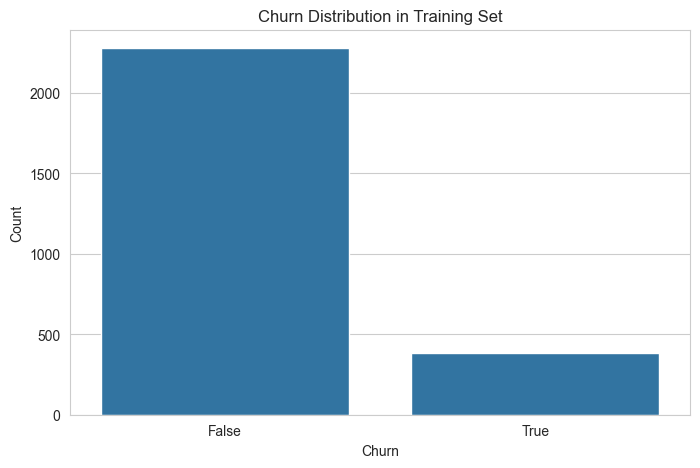

In [56]:
# Simple churn distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title('Churn Distribution in Training Set')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.savefig('images/churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

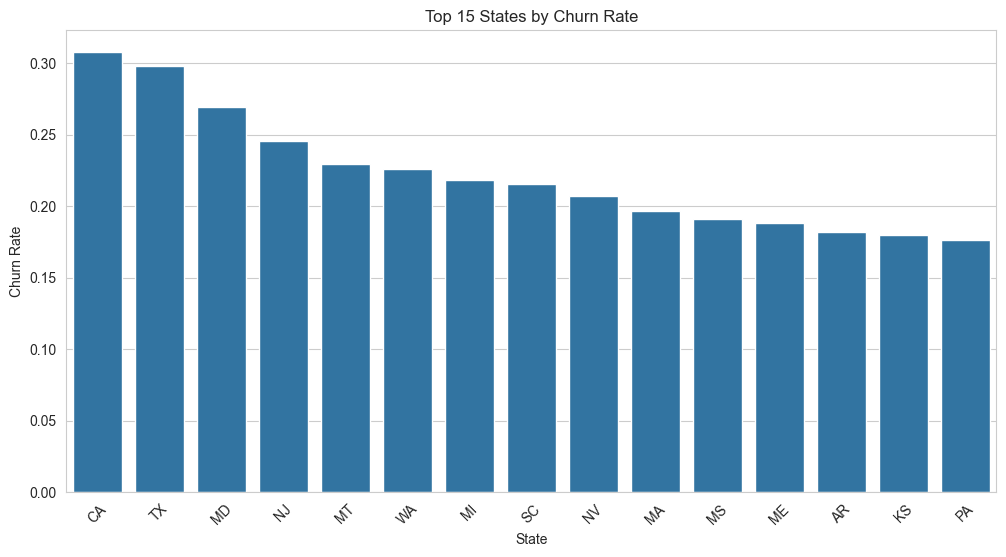

In [57]:
# State vs Churn
state_churn = train_df.groupby('State')['Churn'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=state_churn.index, y=state_churn.values)
plt.title('Top 15 States by Churn Rate')
plt.xlabel('State')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.savefig('images/state_churn_rate.png', dpi=300, bbox_inches='tight')
plt.show()

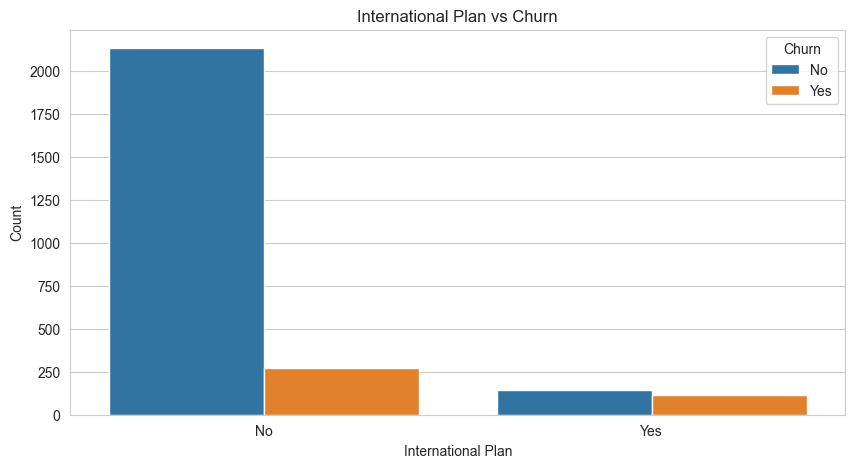

In [58]:
# International Plan vs Churn
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='International plan', hue='Churn')
plt.title('International Plan vs Churn')
plt.xlabel('International Plan')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.savefig('images/international_plan_churn.png', dpi=300, bbox_inches='tight')
plt.show()

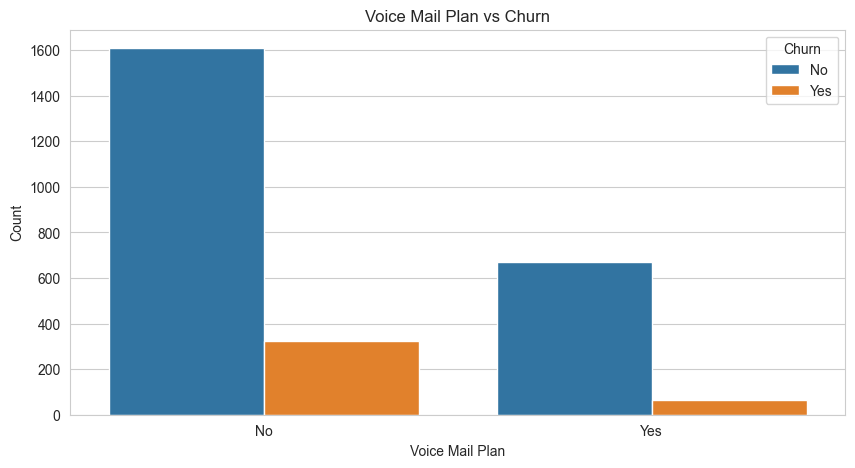

In [59]:
# Voice Mail Plan vs Churn
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='Voice mail plan', hue='Churn')
plt.title('Voice Mail Plan vs Churn')
plt.xlabel('Voice Mail Plan')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.savefig('images/voicemail_plan_churn.png', dpi=300, bbox_inches='tight')
plt.show()

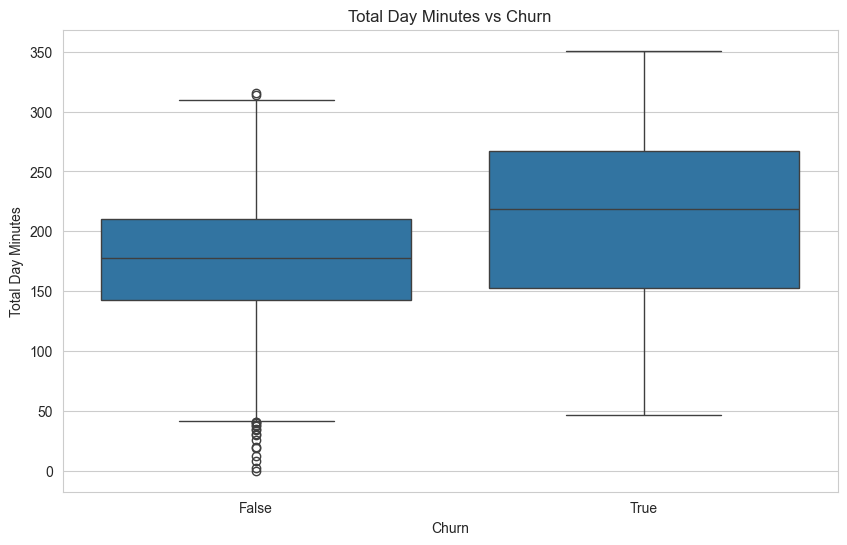

In [60]:
# Total Day Minutes vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Churn', y='Total day minutes')
plt.title('Total Day Minutes vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Day Minutes')
plt.savefig('images/total_day_minutes_churn.png', dpi=300, bbox_inches='tight')
plt.show()

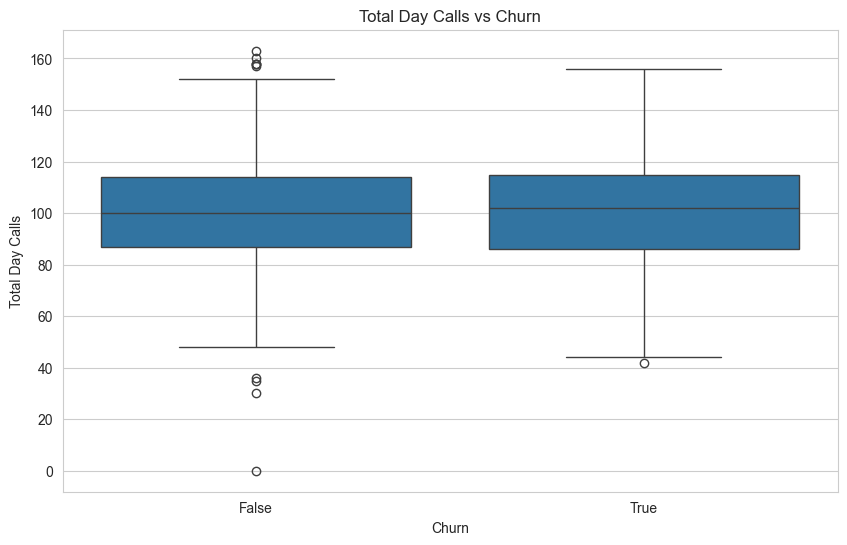

In [61]:
# Total Day Calls vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Churn', y='Total day calls')
plt.title('Total Day Calls vs Churn')
plt.xlabel('Churn')
plt.ylabel('Total Day Calls')
plt.savefig('images/total_day_calls_churn.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

Let's examine the correlations between features and the target variable (Churn).

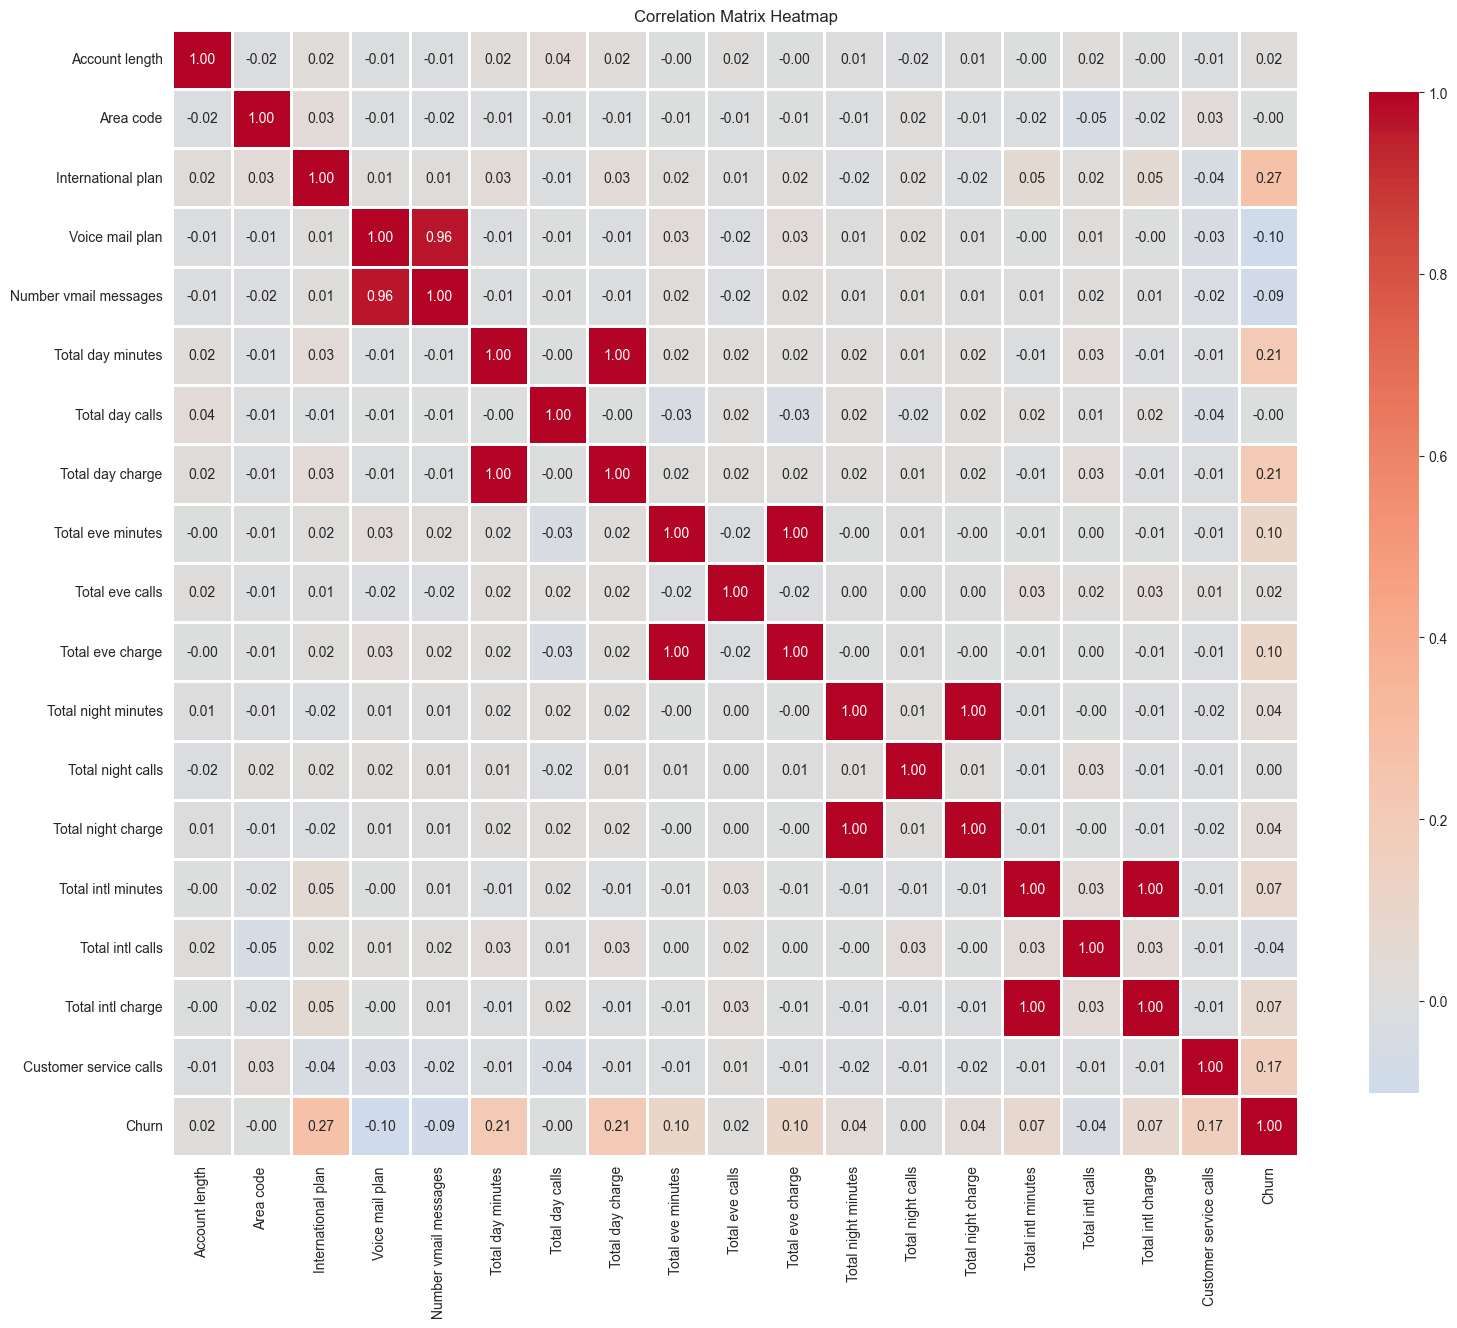

In [63]:
# Create numeric version of train_df for correlation analysis
train_df_numeric = train_df.copy()
train_df_numeric['Churn'] = train_df_numeric['Churn'].astype(int)
train_df_numeric['International plan'] = (train_df_numeric['International plan'] == 'Yes').astype(int)
train_df_numeric['Voice mail plan'] = (train_df_numeric['Voice mail plan'] == 'Yes').astype(int)

# Select only numeric columns for correlation analysis
train_df_numeric = train_df_numeric.select_dtypes(include=[np.number])

# Calculate correlation matrix
correlation_matrix = train_df_numeric.corr()

# Visualize the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# Get correlations with Churn and sort by absolute value
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Features most correlated with Churn:")
print(churn_correlations)

Features most correlated with Churn:
Churn                     1.00
International plan        0.27
Total day minutes         0.21
Total day charge          0.21
Customer service calls    0.17
Total eve minutes         0.10
Total eve charge          0.10
Total intl charge         0.07
Total intl minutes        0.07
Total night charge        0.04
Total night minutes       0.04
Total eve calls           0.02
Account length            0.02
Total night calls         0.00
Area code                -0.00
Total day calls          -0.00
Total intl calls         -0.04
Number vmail messages    -0.09
Voice mail plan          -0.10
Name: Churn, dtype: float64


In [71]:
# Find highly correlated feature pairs (other than with Churn)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                   correlation_matrix.columns[j], 
                                   correlation_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")


Highly correlated feature pairs (|r| > 0.8):
Voice mail plan <-> Number vmail messages: 0.958
Total day minutes <-> Total day charge: 1.000
Total eve minutes <-> Total eve charge: 1.000
Total night minutes <-> Total night charge: 1.000
Total intl minutes <-> Total intl charge: 1.000


In [77]:
# Remove multicollinear features
features_to_remove = ['Total day charge', 'Total eve charge', 'Total night charge', 
                      'Total intl charge', 'Voice mail plan']

print(f"Removing {len(features_to_remove)} features to address multicollinearity:")
for feature in features_to_remove:
    print(f"  - {feature}")

# Create cleaned dataframe
train_df_clean = train_df.copy()
train_df_numeric_clean = train_df_numeric.drop(columns=features_to_remove)

print(f"\nOriginal features: {train_df_numeric.shape[1]}")
print(f"After removing multicollinear features: {train_df_numeric_clean.shape[1]}")
print(f"Features removed: {len(features_to_remove)}")

Removing 5 features to address multicollinearity:
  - Total day charge
  - Total eve charge
  - Total night charge
  - Total intl charge
  - Voice mail plan

Original features: 19
After removing multicollinear features: 14
Features removed: 5


### Addressing Multicollinearity

The correlation analysis revealed perfect multicollinearity (correlation = 1.00) between the 'minutes' and 'charge' features for day, evening, night, and international usage. This is expected since charges are calculated directly from minutes.

Additionally, Voice mail plan and Number vmail messages have a very high correlation (0.96). If a customer has voicemail messages, we know they have a voicemail plan, making the plan variable redundant.


This will eliminate multicollinearity issues and improve model stability and interpretability.

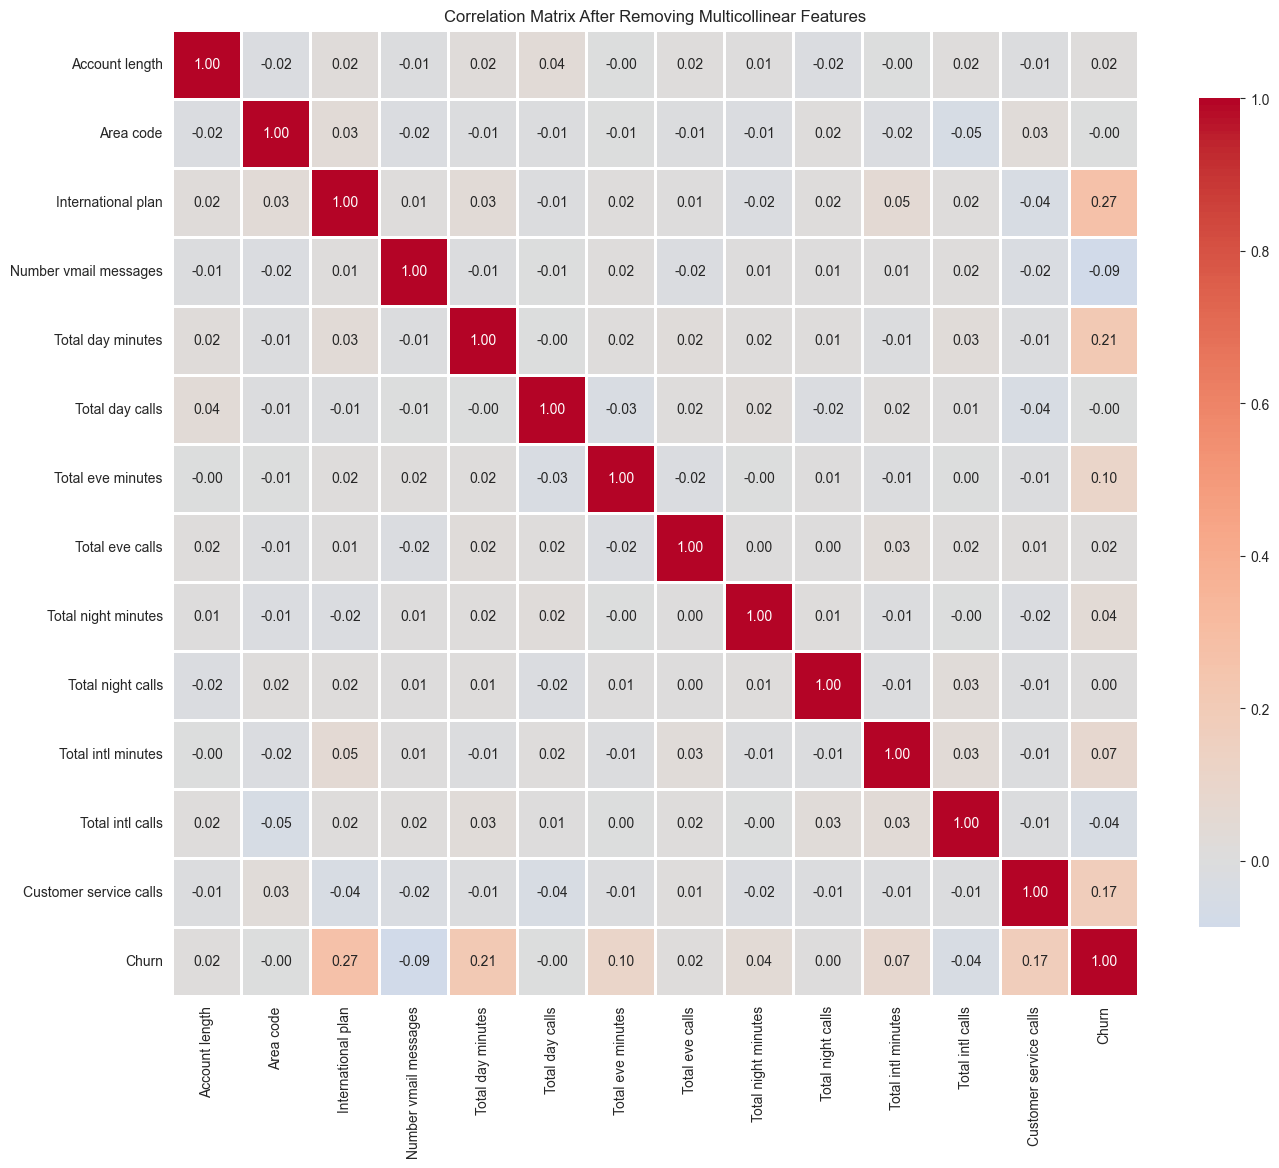


Updated correlations with Churn:
Churn                     1.00
International plan        0.27
Total day minutes         0.21
Customer service calls    0.17
Total eve minutes         0.10
Total intl minutes        0.07
Total night minutes       0.04
Total eve calls           0.02
Account length            0.02
Total night calls         0.00
Area code                -0.00
Total day calls          -0.00
Total intl calls         -0.04
Number vmail messages    -0.09
Name: Churn, dtype: float64


In [79]:
# Recalculate correlation matrix with cleaned features
correlation_matrix_clean = train_df_numeric_clean.corr()

# Visualize the cleaned correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_clean, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix After Removing Multicollinear Features')
plt.tight_layout()
plt.savefig('images/correlation_heatmap_clean.png', dpi=300, bbox_inches='tight')
plt.show()

# Display updated correlations with Churn
print("\nUpdated correlations with Churn:")
print("=" * 60)
churn_correlations_clean = correlation_matrix_clean['Churn'].sort_values(ascending=False)
print(churn_correlations_clean)

### Interpreting the Cleaned Correlation Matrix

**Key Observations:**

1. **No Multicollinearity:** The heatmap now shows no extreme correlations (|r| > 0.8) between predictor variables. All the previously perfect correlations (1.00) between minutes and charges have been eliminated. This is exactly what we want to see.

2. **Why Removing Multicollinearity is Important:**
   - **Model Stability:** When features are highly correlated, model coefficients become unstable and unreliable - small changes in data can cause large swings in coefficients
   - **Interpretation:** It's impossible to determine the individual effect of each feature when they're providing redundant information
   - **Overfitting Risk:** Redundant features can cause models to overfit to noise rather than signal
   - **Computational Efficiency:** Fewer features means faster training and prediction

3. **Remaining Correlations Are Not Concerning:**
   - All feature-to-feature correlations are now moderate (< 0.8), which is acceptable and expected in real-world data
   - Features can have some correlation without causing problems - it's the extreme multicollinearity that's problematic

4. **Top Predictors of Churn:**
   - **International plan (0.27):** You're interpreting this correctly! Customers with international plans have a higher likelihood of churning. This is a positive correlation, meaning as this feature increases (Yes = 1), churn increases. This could indicate that international plan customers are less satisfied or that the pricing doesn't meet their needs.
   - **Total day minutes (0.21):** Customers with higher daytime usage are more likely to churn - possibly due to higher bills
   - **Customer service calls (0.17):** More customer service interactions correlate with higher churn - a red flag indicating dissatisfaction

These correlation values (all < 0.30) are moderate, which is typical for real-world predictive features. Perfect predictors are rare!

### Pairplot of Clean Data

Before moving to preprocessing, visualize relationships among key cleaned features using a pairplot.

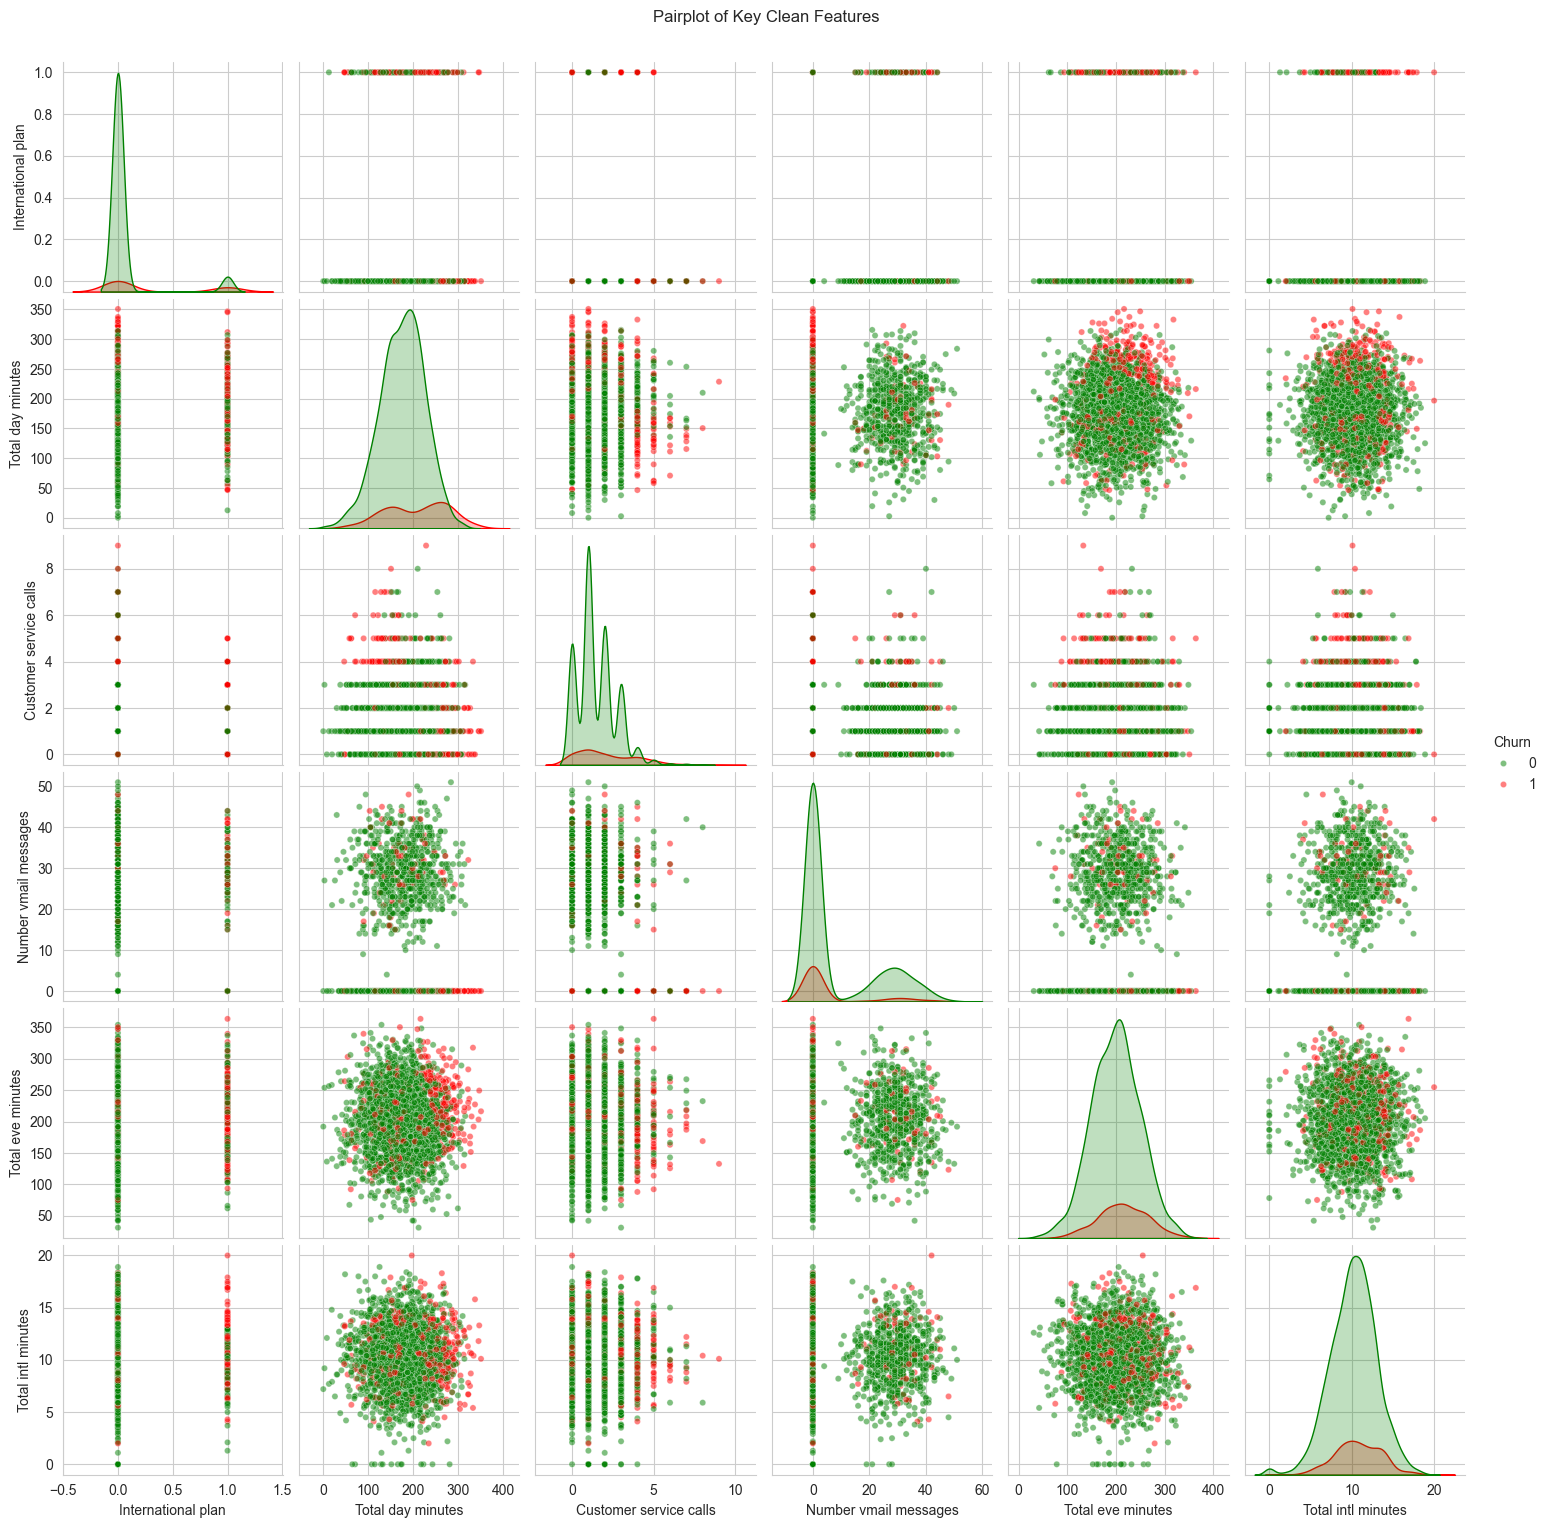

Pairplot created using 7 features


In [114]:
# Pairplot on selected cleaned features (including target)
pairplot_features = [
    'Churn',
    'International plan',
    'Total day minutes',
    'Customer service calls',
    'Number vmail messages',
    'Total eve minutes',
    'Total intl minutes'
]

available_pairplot_features = [col for col in pairplot_features if col in train_df_numeric_clean.columns]
pairplot_df = train_df_numeric_clean[available_pairplot_features].copy()

g = sns.pairplot(
    pairplot_df,
    hue='Churn',
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20},
    palette={0: 'green', 1: 'red'}
)
g.fig.suptitle('Pairplot of Key Clean Features', y=1.02)
plt.savefig('images/pairplot_clean_data.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Pairplot created using {len(available_pairplot_features)} features")

---

## 4. Feature Preprocessing for Modeling

Now we'll prepare the data for machine learning by:
1. Removing multicollinear features identified in EDA
2. Encoding categorical variables
3. Scaling numerical features

In [115]:
# Step 1: Remove multicollinear/redundant features from both train and test sets
# Charges are perfectly tied to minutes; Voice mail plan is redundant with Number vmail messages
# Area code is a coarse geographic proxy and is removed when using State target encoding
features_to_drop = ['Total day charge', 'Total eve charge', 'Total night charge',
                    'Total intl charge', 'Voice mail plan', 'Area code']

X_train_processed = X_train.drop(columns=features_to_drop)
X_test_processed = X_test.drop(columns=features_to_drop)

print(f"Original features: {X_train.shape[1]}")
print(f"After dropping selected features: {X_train_processed.shape[1]}")
print(f"\nDropped: {features_to_drop}")

Original features: 19
After dropping selected features: 13

Dropped: ['Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge', 'Voice mail plan', 'Area code']


In [116]:
# Step 2: Encode categorical variables
# International plan: Binary (Yes/No) -> 0/1
# State: Target encoding using TRAIN set only (prevents leakage)
# Churn (target): Convert True/False -> 1/0

# Encode binary variable (International plan)
X_train_processed['International plan'] = (X_train_processed['International plan'] == 'Yes').astype(int)
X_test_processed['International plan'] = (X_test_processed['International plan'] == 'Yes').astype(int)

# Target encode State using training churn rate per state
global_churn_rate = y_train.mean()
state_target_map = y_train.groupby(X_train_processed['State']).mean()

X_train_processed['State_te'] = X_train_processed['State'].map(state_target_map)
X_test_processed['State_te'] = X_test_processed['State'].map(state_target_map).fillna(global_churn_rate)

# Drop original State after encoding
X_train_processed = X_train_processed.drop(columns=['State'])
X_test_processed = X_test_processed.drop(columns=['State'])

# Encode target variable (Churn)
y_train_processed = y_train.astype(int)
y_test_processed = y_test.astype(int)

# Diagnostics
unseen_test_states = (~X_test['State'].isin(state_target_map.index)).sum()

print(f"\nAfter encoding:")
print(f"Training features: {X_train_processed.shape[1]}")
print(f"Training samples: {X_train_processed.shape[0]}")
print(f"Global churn rate used for fallback: {global_churn_rate:.4f}")
print(f"Unseen states in test set: {unseen_test_states}")
print(f"\nFeature types:")
print(X_train_processed.dtypes.value_counts())


After encoding:
Training features: 13
Training samples: 2666
Global churn rate used for fallback: 0.1448
Unseen states in test set: 0

Feature types:
int64      8
float64    5
Name: count, dtype: int64


**Encoding Explanation:**
- **International plan** (binary): Converted Yes/No → 1/0 (one column is sufficient for binary variables)
- **State** (51 categories): Target encoded using training-set churn rate per state (`State_te`)
- **Churn** (target): Converted True/False → 1/0 (stored separately in y_train_processed, y_test_processed)
- **Area code**: Dropped as a coarse geographic proxy with limited additional signal once `State_te` is used

Note: Target encoding avoids creating many dummy columns and keeps the geographic signal compact. The mapping is learned only from training data, and unseen test states (if any) fall back to global churn rate.

In [109]:
X_train_processed.head()

,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,State_te
3290,27,0,0,227.40,67,248.00,115,61.40,109,7.80,6,1,0.11
93,36,1,42,196.80,89,254.90,122,138.30,126,20.00,6,0,0.19
1341,174,0,15,221.80,143,210.60,115,221.80,109,12.40,9,1,0.18
1661,65,0,23,224.20,106,189.60,100,222.80,75,9.80,4,0,0.18
2997,155,0,0,163.00,93,203.90,102,159.00,109,15.10,4,2,0.19


In [110]:
# 1) Select numeric columns
num_df = train_df_numeric_clean.select_dtypes(include='number')

# 2) (Optional) remove target/binary columns from skew check
num_df = num_df.drop(columns=['Churn', 'International plan'], errors='ignore')

# 3) Compute skewness and sort by absolute skew
skew_vals = num_df.skew().sort_values(key=lambda s: s.abs(), ascending=False)

print("Skewness by feature:")
print(skew_vals)

print("\nModerate/High skew (|skew| > 0.5):")
print(skew_vals[skew_vals.abs() > 0.5])

Skewness by feature:
Total intl calls          1.30
Number vmail messages     1.27
Area code                 1.16
Customer service calls    1.08
Total intl minutes       -0.22
Account length            0.08
Total day calls          -0.08
Total night calls         0.07
Total day minutes        -0.03
Total eve minutes        -0.01
Total eve calls          -0.01
Total night minutes      -0.01
dtype: float64

Moderate/High skew (|skew| > 0.5):
Total intl calls         1.30
Number vmail messages    1.27
Area code                1.16
Customer service calls   1.08
dtype: float64


In [117]:
# Step 3: Apply log1p transformation to selected skewed count features
# log1p(x) = log(1 + x) handles zeros safely and reduces right-skew.
# We transform ONLY the agreed three variables.

requested_log1p_features = ['Total intl calls', 'Number vmail messages', 'Customer service calls']

# Keep only features that exist in processed data
log1p_features = [col for col in requested_log1p_features if col in X_train_processed.columns]
missing_features = [col for col in requested_log1p_features if col not in X_train_processed.columns]

if log1p_features:
    X_train_processed[log1p_features] = np.log1p(X_train_processed[log1p_features])
    X_test_processed[log1p_features] = np.log1p(X_test_processed[log1p_features])

print(f"Requested log1p features: {requested_log1p_features}")
print(f"Transformed features: {log1p_features if log1p_features else 'None'}")
if missing_features:
    print(f"Missing (not found in processed data): {missing_features}")

Requested log1p features: ['Total intl calls', 'Number vmail messages', 'Customer service calls']
Transformed features: ['Total intl calls', 'Number vmail messages', 'Customer service calls']


In [119]:
# Step 4: Scale numerical features (fit on train, apply to test)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_columns = X_train_processed.columns.tolist()
X_train_processed[numeric_columns] = scaler.fit_transform(X_train_processed[numeric_columns])
X_test_processed[numeric_columns] = scaler.transform(X_test_processed[numeric_columns])

print("Scaling complete.")
print(f"Scaled {len(numeric_columns)} feature(s).")
print("Train feature means (first 5):")
print(X_train_processed.mean().head())

Scaling complete.
Scaled 13 feature(s).
Train feature means (first 5):
Account length          -0.00
International plan      -0.00
Number vmail messages   -0.00
Total day minutes       -0.00
Total day calls          0.00
dtype: float64


### Why use `log1p` for the selected count features?

We apply `log1p(x) = log(1 + x)` to these three features:
- `Total intl calls`
- `Number vmail messages`
- `Customer service calls`

Reasoning:
- **Handles zeros safely:** `log(0)` is undefined, but `log1p(0) = 0`
- **Reduces right skew:** compresses large values and makes distributions less long-tailed
- **Stabilizes variance:** can help models that are sensitive to feature scale/distribution
- **Prevents leakage:** the same transform is applied consistently to train and test data

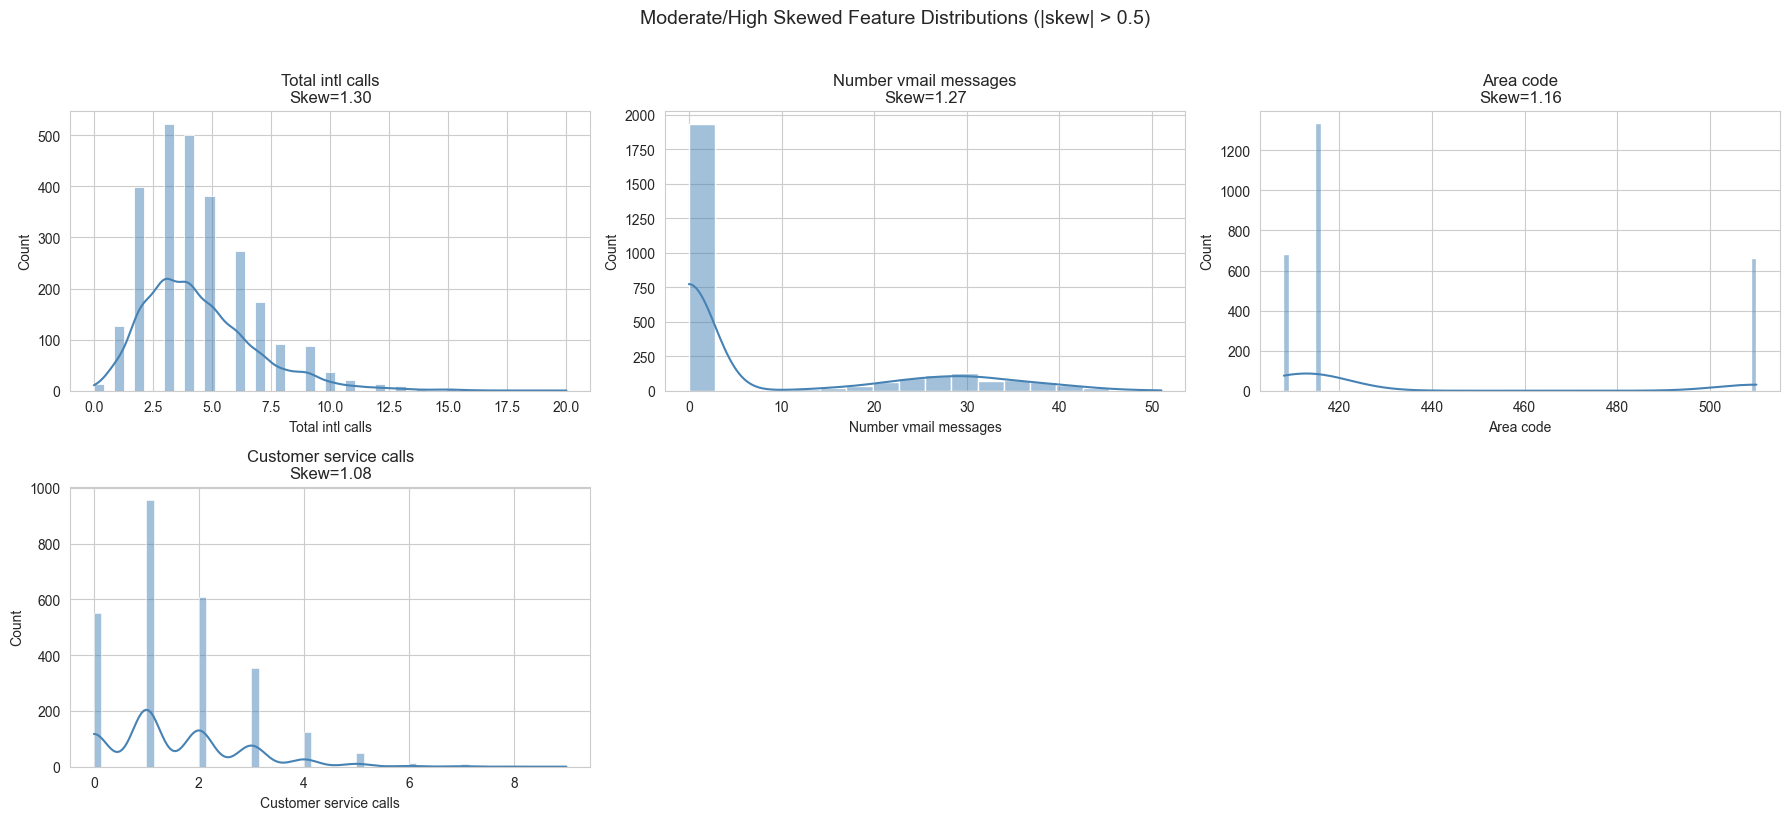

Plotted 4 moderate/high skewed feature(s)
Saved: images/skewed_features_hist.png


In [120]:
# Plot distributions for moderate/high skewed features
moderate_high_skew = skew_vals[skew_vals.abs() > 0.5]

if moderate_high_skew.empty:
    print("No moderate/high skewed features found (|skew| > 0.5).")
else:
    skewed_features = moderate_high_skew.index.tolist()
    n_features = len(skewed_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    for i, feature in enumerate(skewed_features):
        sns.histplot(num_df[feature], kde=True, ax=axes[i], color='steelblue')
        axes[i].set_title(f"{feature}\nSkew={moderate_high_skew[feature]:.2f}")
        axes[i].set_xlabel(feature)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Moderate/High Skewed Feature Distributions (|skew| > 0.5)', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.savefig('images/skewed_features_hist.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Plotted {n_features} moderate/high skewed feature(s)")
    print("Saved: images/skewed_features_hist.png")

---

## 5. Baseline Modeling (No SMOTE)

We start with a baseline model **without SMOTE** and use class weighting to handle imbalance. We evaluate with recall, F1, ROC-AUC, and PR-AUC for churn performance.

In [123]:
# Train baseline logistic regression (no SMOTE) with CV-based threshold tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    recall_score
)

# Define model
baseline_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# 1) Tune threshold using cross-validated out-of-fold probabilities on TRAIN only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = cross_val_predict(
    baseline_model,
    X_train_processed,
    y_train_processed,
    cv=cv,
    method='predict_proba'
)[:, 1]

prec_cv, rec_cv, thresholds_cv = precision_recall_curve(y_train_processed, oof_proba)

# Tune for recall: find threshold that gives highest recall while maintaining at least moderate precision
# Or use the threshold closest to target recall (e.g., 0.80)
target_recall = 0.80
recall_diffs = np.abs(rec_cv[:-1] - target_recall)
best_idx = np.argmin(recall_diffs)
best_threshold = thresholds_cv[best_idx]

print("Cross-Validation Threshold Tuning for Recall (TRAIN only)")
print("=" * 60)
print(f"Best threshold (tuned for recall ~{target_recall:.2f}): {best_threshold:.4f}")
print(f"CV-Recall @ this threshold: {rec_cv[best_idx]:.4f}")
print(f"CV-Precision @ this threshold: {prec_cv[best_idx]:.4f}")

# 2) Fit on full training set
baseline_model.fit(X_train_processed, y_train_processed)

# 3) Final one-time evaluation on TEST set
y_proba = baseline_model.predict_proba(X_test_processed)[:, 1]
y_pred_default = (y_proba >= 0.5).astype(int)
y_pred_tuned = (y_proba >= best_threshold).astype(int)

roc_auc = roc_auc_score(y_test_processed, y_proba)
pr_auc = average_precision_score(y_test_processed, y_proba)

print("\nFinal Test Evaluation (holdout)")
print("=" * 60)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print(f"\n@ default threshold (0.50):")
print(f"  Recall: {recall_score(y_test_processed, y_pred_default):.4f}")
print(f"  F1:     {f1_score(y_test_processed, y_pred_default):.4f}")
print(f"\n@ tuned threshold ({best_threshold:.4f}) [recall-optimized]:")
print(f"  Recall: {recall_score(y_test_processed, y_pred_tuned):.4f}")
print(f"  F1:     {f1_score(y_test_processed, y_pred_tuned):.4f}")

print("\nConfusion Matrix @ tuned threshold:")
print(confusion_matrix(y_test_processed, y_pred_tuned))

print("\nClassification Report @ tuned threshold:")
print(classification_report(y_test_processed, y_pred_tuned, digits=4))

Cross-Validation Threshold Tuning for Recall (TRAIN only)
Best threshold (tuned for recall ~0.80): 0.3871
CV-Recall @ this threshold: 0.8005
CV-Precision @ this threshold: 0.2545

Final Test Evaluation (holdout)
ROC-AUC: 0.7977
PR-AUC:  0.4473

@ default threshold (0.50):
  Recall: 0.6701
  F1:     0.4392

@ tuned threshold (0.3871) [recall-optimized]:
  Recall: 0.8041
  F1:     0.4116

Confusion Matrix @ tuned threshold:
[[366 204]
 [ 19  78]]

Classification Report @ tuned threshold:
              precision    recall  f1-score   support

           0     0.9506    0.6421    0.7665       570
           1     0.2766    0.8041    0.4116        97

    accuracy                         0.6657       667
   macro avg     0.6136    0.7231    0.5891       667
weighted avg     0.8526    0.6657    0.7149       667



## 6. Multi-Model Cross-Validation Comparison

Now we compare multiple algorithms using **stratified 5-fold cross-validation** to evaluate which model performs best:

1. **Logistic Regression** (baseline - already trained)
2. **Random Forest** - Ensemble of decision trees
3. **Gradient Boosting** - Sequential boosting
4. **XGBoost** - Optimized gradient boosting
5. **Voting Classifier** - Ensemble combining best models

### Hyperparameter Tuning Strategy

**Phase 1 (This section):** Train models with **reasonable default hyperparameters** and compare CV performance
- Identify 1-2 best-performing models
- Establish baseline metrics

**Phase 2 (Later):** Run **GridSearchCV or RandomizedSearchCV** on the best model(s)
- Fine-tune hyperparameters within the top performer
- Optimize specifically for recall/business metrics
- Validate on holdout test set

This two-phase approach is more efficient than tuning all models upfront.

In [124]:
# Multi-model cross-validation comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import cross_validate
import xgboost as xgb
import pandas as pd

# Define models with reasonable default hyperparameters
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=RANDOM_STATE
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train_processed == 0).sum() / (y_train_processed == 1).sum(),
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
}

# Define custom scoring functions for recall, F1, ROC-AUC, PR-AUC
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score

scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score)
}

# Run cross-validation for each model
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Cross-Validation Results (5-Fold Stratified)")
print("=" * 80)

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    cv_result = cross_validate(
        model,
        X_train_processed,
        y_train_processed,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    cv_results[model_name] = cv_result
    
    # Print fold-level results
    print(f"  Fold Recall:   {cv_result['test_recall'].mean():.4f} (±{cv_result['test_recall'].std():.4f})")
    print(f"  Fold F1:       {cv_result['test_f1'].mean():.4f} (±{cv_result['test_f1'].std():.4f})")
    print(f"  Fold ROC-AUC:  {cv_result['test_roc_auc'].mean():.4f} (±{cv_result['test_roc_auc'].std():.4f})")
    print(f"  Fold PR-AUC:   {cv_result['test_pr_auc'].mean():.4f} (±{cv_result['test_pr_auc'].std():.4f})")

# Create comparison dataframe
comparison_data = []
for model_name, cv_result in cv_results.items():
    comparison_data.append({
        'Model': model_name,
        'Recall (mean)': cv_result['test_recall'].mean(),
        'Recall (std)': cv_result['test_recall'].std(),
        'F1 (mean)': cv_result['test_f1'].mean(),
        'F1 (std)': cv_result['test_f1'].std(),
        'ROC-AUC (mean)': cv_result['test_roc_auc'].mean(),
        'ROC-AUC (std)': cv_result['test_roc_auc'].std(),
        'PR-AUC (mean)': cv_result['test_pr_auc'].mean(),
        'PR-AUC (std)': cv_result['test_pr_auc'].std()
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("\nCOMPARISON TABLE (5-Fold CV Means)")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best models
best_by_recall = comparison_df.loc[comparison_df['Recall (mean)'].idxmax()]
best_by_roc_auc = comparison_df.loc[comparison_df['ROC-AUC (mean)'].idxmax()]
best_by_pr_auc = comparison_df.loc[comparison_df['PR-AUC (mean)'].idxmax()]

print(f"\n\nBEST MODELS:")
print("=" * 80)
print(f"Highest Recall:  {best_by_recall['Model']} ({best_by_recall['Recall (mean)']:.4f})")
print(f"Highest ROC-AUC: {best_by_roc_auc['Model']} ({best_by_roc_auc['ROC-AUC (mean)']:.4f})")
print(f"Highest PR-AUC:  {best_by_pr_auc['Model']} ({best_by_pr_auc['PR-AUC (mean)']:.4f})")


Cross-Validation Results (5-Fold Stratified)

Training Logistic Regression...
  Fold Recall:   0.7150 (±0.0170)
  Fold F1:       0.4543 (±0.0197)
  Fold ROC-AUC:  0.7358 (±0.0126)
  Fold PR-AUC:   0.2797 (±0.0151)

Training Random Forest...
  Fold Recall:   0.7487 (±0.0178)
  Fold F1:       0.7741 (±0.0200)
  Fold ROC-AUC:  0.8586 (±0.0087)
  Fold PR-AUC:   0.6373 (±0.0311)

Training Gradient Boosting...
  Fold Recall:   0.7460 (±0.0251)
  Fold F1:       0.8298 (±0.0237)
  Fold ROC-AUC:  0.8686 (±0.0136)
  Fold PR-AUC:   0.7351 (±0.0372)

Training XGBoost...
  Fold Recall:   0.8005 (±0.0212)
  Fold F1:       0.7955 (±0.0174)
  Fold ROC-AUC:  0.8823 (±0.0104)
  Fold PR-AUC:   0.6624 (±0.0260)


COMPARISON TABLE (5-Fold CV Means)
              Model  Recall (mean)  Recall (std)  F1 (mean)  F1 (std)  ROC-AUC (mean)  ROC-AUC (std)  PR-AUC (mean)  PR-AUC (std)
Logistic Regression           0.71          0.02       0.45      0.02            0.74           0.01           0.28          0.02
  

In [ ]:
print("\n✓ Model comparison complete using ONLY training data + CV")
print("✓ Test set has been preserved and NOT touched during model selection")
print("\nNext steps:")
print("1. Review the CV comparison table above")
print("2. Identify the best model (usually by highest ROC-AUC or closest to target recall)")
print("3. Proceed to hyperparameter tuning (Section 7) on the best model")
print("4. ONLY evaluate final model on test set at the very end")

---

## 7. Hyperparameter Tuning for Best Model

After identifying the best-performing model from cross-validation, we can fine-tune its hyperparameters using **GridSearchCV** or **RandomizedSearchCV** to optimize for our target metric (recall or ROC-AUC).

### When to Tune?

✓ **After** identifying 1-2 best baseline models (Phase 1 - done above)
✓ **Focus tuning** on the specific metric that matters for business (here: recall)
✓ **Use stratified K-fold CV** when evaluating hyperparameter combinations
✓ **Validate final model** on the holdout test set

### What Gets Tuned?

For each model type:
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
- **XGBoost**: `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`
- **Gradient Boosting**: `learning_rate`, `max_depth`, `n_estimators`, `subsample`
- **Logistic Regression**: `C` (regularization strength), `solver`, `class_weight`

### Next Steps

Uncomment and run the cell below to perform GridSearchCV on your best model.

In [ ]:
# Hyperparameter Tuning for Random Forest, Gradient Boosting, and XGBoost
from sklearn.model_selection import GridSearchCV
import time

print("=" * 80)
print("HYPERPARAMETER TUNING (Phase 2)")
print("=" * 80)
print("Tuning best models using GridSearchCV with stratified 5-fold CV")
print("Optimizing for: Recall (maximizing churn detection)\n")

tuned_results = {}

# ============================================================================
# 1. Random Forest Tuning
# ============================================================================
print("\n" + "-" * 80)
print("1. RANDOM FOREST - GridSearchCV")
print("-" * 80)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 8],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

grid_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split']) * len(param_grid_rf['min_samples_leaf']) * len(param_grid_rf['max_features'])} combinations")
print("Training...")
start_time = time.time()
grid_rf.fit(X_train_processed, y_train_processed)
rf_time = time.time() - start_time

print(f"\n✓ Random Forest tuning complete ({rf_time:.1f}s)")
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best CV Recall: {grid_rf.best_score_:.4f}")

tuned_results['Random Forest'] = {
    'model': grid_rf.best_estimator_,
    'best_params': grid_rf.best_params_,
    'best_score': grid_rf.best_score_,
    'time': rf_time
}

# ============================================================================
# 2. Gradient Boosting Tuning
# ============================================================================
print("\n" + "-" * 80)
print("2. GRADIENT BOOSTING - GridSearchCV")
print("-" * 80)

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 8],
    'subsample': [0.6, 0.8, 1.0]
}

gb_base = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)

grid_gb = GridSearchCV(
    gb_base,
    param_grid_gb,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_gb['n_estimators']) * len(param_grid_gb['learning_rate']) * len(param_grid_gb['max_depth']) * len(param_grid_gb['min_samples_split']) * len(param_grid_gb['min_samples_leaf']) * len(param_grid_gb['subsample'])} combinations")
print("Training...")
start_time = time.time()
grid_gb.fit(X_train_processed, y_train_processed)
gb_time = time.time() - start_time

print(f"\n✓ Gradient Boosting tuning complete ({gb_time:.1f}s)")
print(f"Best parameters: {grid_gb.best_params_}")
print(f"Best CV Recall: {grid_gb.best_score_:.4f}")

tuned_results['Gradient Boosting'] = {
    'model': grid_gb.best_estimator_,
    'best_params': grid_gb.best_params_,
    'best_score': grid_gb.best_score_,
    'time': gb_time
}

# ============================================================================
# 3. XGBoost Tuning
# ============================================================================
print("\n" + "-" * 80)
print("3. XGBOOST - GridSearchCV")
print("-" * 80)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [2, 5, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_base = xgb.XGBClassifier(
    scale_pos_weight=(y_train_processed == 0).sum() / (y_train_processed == 1).sum(),
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    n_jobs=-1
)

grid_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    cv=cv,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print(f"Parameter grid size: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['min_child_weight']) * len(param_grid_xgb['subsample']) * len(param_grid_xgb['colsample_bytree'])} combinations")
print("Training...")
start_time = time.time()
grid_xgb.fit(X_train_processed, y_train_processed)
xgb_time = time.time() - start_time

print(f"\n✓ XGBoost tuning complete ({xgb_time:.1f}s)")
print(f"Best parameters: {grid_xgb.best_params_}")
print(f"Best CV Recall: {grid_xgb.best_score_:.4f}")

tuned_results['XGBoost'] = {
    'model': grid_xgb.best_estimator_,
    'best_params': grid_xgb.best_params_,
    'best_score': grid_xgb.best_score_,
    'time': xgb_time
}

# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "=" * 80)
print("TUNING SUMMARY")
print("=" * 80)

summary_data = []
for model_name, results in tuned_results.items():
    summary_data.append({
        'Model': model_name,
        'Best CV Recall': results['best_score'],
        'Tuning Time (s)': f"{results['time']:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Identify best tuned model
best_tuned_model_name = max(tuned_results.items(), key=lambda x: x[1]['best_score'])[0]
print(f"\n✓ Best tuned model: {best_tuned_model_name} (CV Recall: {tuned_results[best_tuned_model_name]['best_score']:.4f})")

---

## 8. Final Test Set Evaluation

After completing hyperparameter tuning on the best model, we perform ONE final evaluation on the holdout test set. This is the **ONLY time** we touch the test set - giving us an honest, unbiased estimate of model performance.

### Key Rules for Proper Validation:
✓ Train/CV happens on 80% training data only  
✓ Test set is completely isolated until final evaluation  
✓ Final evaluation is performed exactly once  
✓ Results on test set are reported as your best estimate of production performance

In [ ]:
# Final Test Set Evaluation (AFTER all tuning is complete)
# This cell should be run ONLY after:
# 1. Selecting best model from Section 6
# 2. Hyperparameter tuning (Section 7)
# 3. Threshold tuning (still using training CV, not test set)

# Replace best_model with your tuned model
best_model = models['XGBoost']  # Change to your selected model name

# Fit on FULL training set
best_model.fit(X_train_processed, y_train_processed)

# Get probabilities on test set (first and only time we use test)
y_proba_test = best_model.predict_proba(X_test_processed)[:, 1]

# Use threshold tuned on training CV (not on test set)
# Threshold was tuned in training CV - we reuse it here
target_recall = 0.80
# Re-compute threshold using CV on training (not touching test)
oof_proba_train = cross_val_predict(
    best_model.__class__(**best_model.get_params()),
    X_train_processed,
    y_train_processed,
    cv=cv,
    method='predict_proba'
)[:, 1]
prec_cv, rec_cv, thresholds_cv = precision_recall_curve(y_train_processed, oof_proba_train)
recall_diffs = np.abs(rec_cv[:-1] - target_recall)
best_idx = np.argmin(recall_diffs)
best_threshold = thresholds_cv[best_idx]

# Apply to test set
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# Evaluate ONCE on test set
roc_auc_test = roc_auc_score(y_test_processed, y_proba_test)
pr_auc_test = average_precision_score(y_test_processed, y_proba_test)
recall_test = recall_score(y_test_processed, y_pred_test)
f1_test = f1_score(y_test_processed, y_pred_test)

print("=" * 80)
print("FINAL TEST SET EVALUATION (Holdout - First and Only Time)")
print("=" * 80)
print(f"\nModel: {list(models.keys())[list(models.values()).index(best_model)]}")
print(f"Threshold: {best_threshold:.4f} (tuned on training CV, not on test)")
print(f"\nTest Set Performance:")
print(f"  ROC-AUC:  {roc_auc_test:.4f}")
print(f"  PR-AUC:   {pr_auc_test:.4f}")
print(f"  Recall:   {recall_test:.4f}")
print(f"  F1:       {f1_test:.4f}")

print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test_processed, y_pred_test))

print(f"\nClassification Report:")
print(classification_report(y_test_processed, y_pred_test, digits=4))